# 卷积

In [11]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda import gpuarray
from pycuda.reduction import ReductionKernel
from pycuda.elementwise import ElementwiseKernel
import time
import numpy as np
from pycuda.compiler import SourceModule
import string
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [2]:
src = cv2.imread('../../datas/f3.jpg')
rgb = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)

In [3]:
def load_kernel_from_file(fname,kname):
    sources = None
    kernel = None
    with open(fname,encoding='utf-8') as f:
        sources = f.read() # 通过str函数转换为unicode编码
        sm = SourceModule(str(sources))
        kernel = sm.get_function(kname)
    return kernel

def load_kernel_from_string(sources,kname):
    sm = SourceModule(str(sources))
    kernel = sm.get_function(kname)
    return kernel

In [26]:
convolution_channel = load_kernel_from_file('../../datas/cuda/36-convolution.cu','convolution_kernel_single_channel')

In [20]:
rows,cols = gray.shape
block = (1,1,1)
grid = (int(cols/block[0]),int(rows/block[1]),1)

In [21]:
sr = rgb[:,:,0].copy().astype(np.float32)
sg = rgb[:,:,1].copy().astype(np.float32)
sb = rgb[:,:,2].copy().astype(np.float32)

In [32]:
avg_blur = np.ones((11,11),dtype=np.float32)/121

In [33]:
dr = np.zeros_like(sr)
dg = np.zeros_like(sr)
db = np.zeros_like(sr)
convolution_channel(cuda.In(sr),cuda.Out(dr),np.int32(cols),np.int32(rows),cuda.In(avg_blur),np.int32(11),block=block,grid=grid)
convolution_channel(cuda.In(sg),cuda.Out(dg),np.int32(cols),np.int32(rows),cuda.In(avg_blur),np.int32(11),block=block,grid=grid)
convolution_channel(cuda.In(sb),cuda.Out(db),np.int32(cols),np.int32(rows),cuda.In(avg_blur),np.int32(11),block=block,grid=grid)

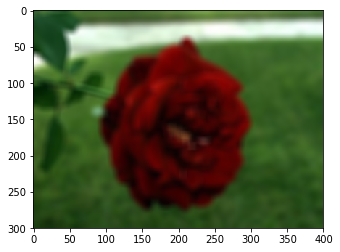

In [39]:
dst = cv2.merge([dr,dg,db])
dst = np.clip(dst,0,255)
dst = np.uint8(dst)
plt.imshow(dst)

In [40]:
sobel_x = np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
],dtype=np.float32)
sobel_y = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
],dtype=np.float32)

In [41]:
grayf = np.float32(gray)
dst_x = np.zeros_like(grayf)
dst_y = np.zeros_like(grayf)
dst_xy = np.zeros_like(grayf)
convolution_channel(cuda.In(grayf),cuda.Out(dst_x),np.int32(cols),np.int32(rows),cuda.In(sobel_x),np.int32(3),block=block,grid=grid)
convolution_channel(cuda.In(grayf),cuda.Out(dst_y),np.int32(cols),np.int32(rows),cuda.In(sobel_x),np.int32(3),block=block,grid=grid)


In [42]:
dst = dst_x + dst_y

In [44]:
dst_x = np.clip(dst_x,0,255)
dst_x = np.uint8(dst_x)
dst_y = np.clip(dst_y,0,255)
dst_y = np.uint8(dst_y)
dst = np.clip(dst,0,255)
dst = np.uint8(dst)

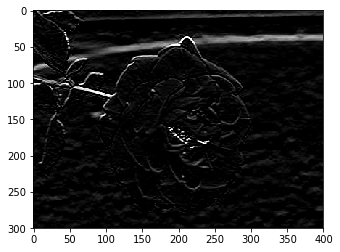

In [45]:
plt.imshow(dst_x,'gray')

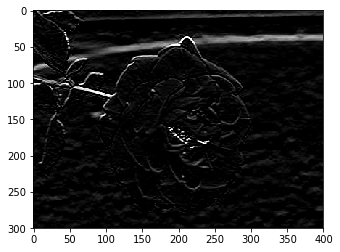

In [46]:
plt.imshow(dst_y,'gray')

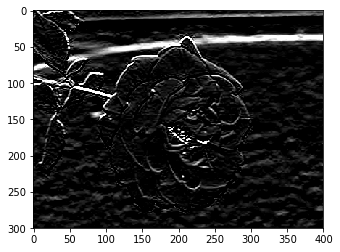

In [47]:
plt.imshow(dst,'gray')